# PDE-FIND for Burger's Equation

Samuel Rudy, 2016

This notebook demonstrates PDE-FIND on Burger's equation with an added diffusive term.
$$
u_t + uu_x = 0.1u_{xx}
$$
The solution given is a single travelling wave, starting out as a Gaussian.

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import warnings; warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sympy import symbols

import sys; sys.path.append('../')
from PDE_FIND import *

import sys; sys.path.append('../../parametric-discovery/')
from best_subset import *
from frols import frols
from p_linear_regression import PLinearRegression
from r_pca import R_pca
from pde_diff_new import RPCA
from RobustPCA.rpca import RobustPCA

import scipy.io as sio
from scipy.signal import savgol_filter
import itertools

from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression as SkLinearRegression
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from abess.linear import LinearRegression
from bess import PdasLm
import pysindy as ps

from os.path import join as join_path
FIGURE_EXPORT_PATH = "/Users/pongpisit/Documents/figure_export/"

# from rad import AnomalyDetection_RPCA

def evaluate_coefficients(prediected_coeffs):
    GROUND = np.array([0.1, -1])
    errs = 100*np.abs(GROUND-np.array(prediected_coeffs).flatten())/np.abs(GROUND)
    return errs.mean(), errs.std()

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = sio.loadmat('../Datasets/burgers.mat')
u = real(data['usol'])
x = real(data['x'][0])
t = real(data['t'][:,0])
dt = t[1]-t[0]
dx = x[2]-x[1]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

cmap = viridis


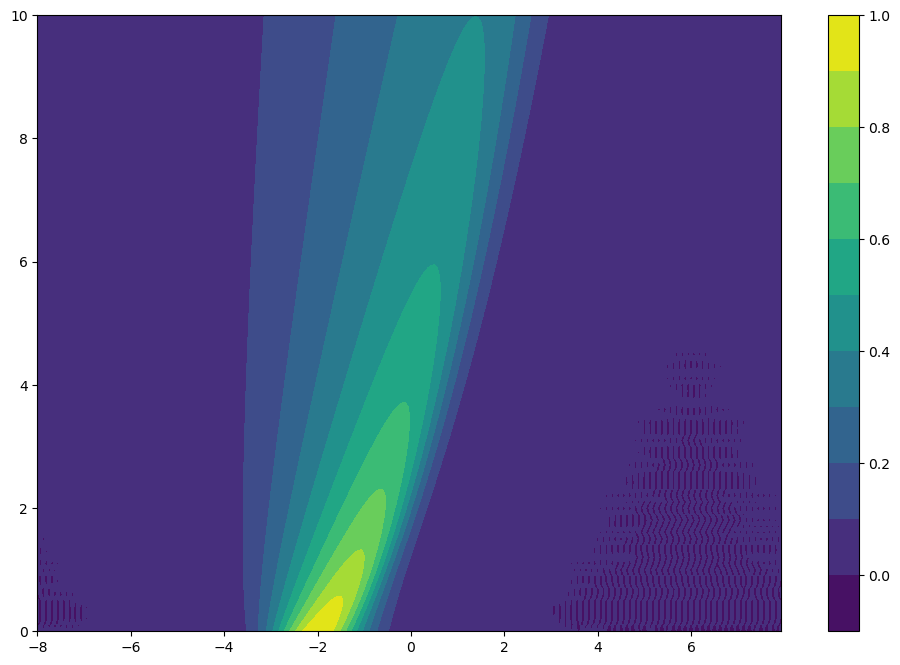

In [3]:
from matplotlib import cm
cmap_name = cm.get_cmap().name
print("cmap =", cmap_name)

plt.contourf(X, T, u.T, levels=10, cmap=cmap_name)
plt.colorbar()
plt.show()

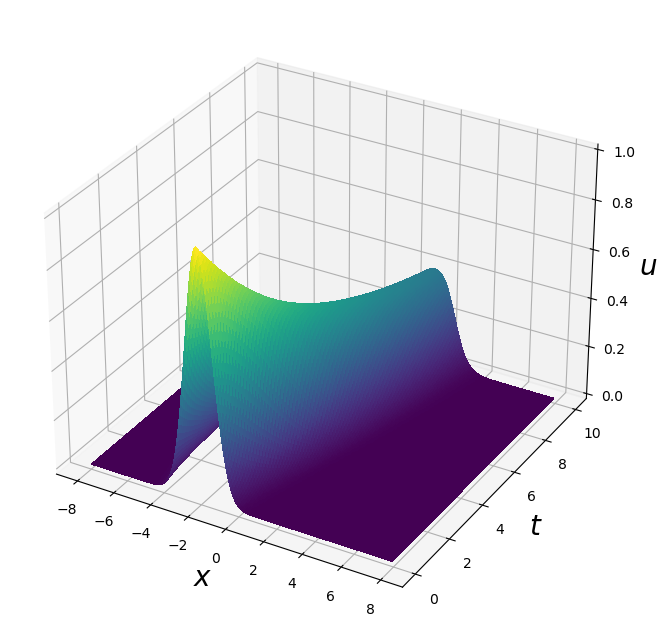

In [4]:
fig = figure()
ax = fig.gca(projection='3d')
ax.set_zlabel("$u$", fontsize=20)
ax.set_xlabel("$x$", fontsize=20)
ax.set_ylabel("$t$", fontsize=20)
surf = ax.plot_surface(X, T, u.T, 
                       rstride=1, cstride=1, cmap=cmap_name, 
                       linewidth=1, antialiased=False)
# plt.title("Burgers' PDE", fontsize=20)
# plt.savefig(fname=join_path(FIGURE_EXPORT_PATH, "burgers3d.png"), dpi=300)
plt.show()

In [5]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(np.expand_dims(u, -1), t=dt)
model.print()

STLSQ model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1


## Construct $\Theta (U)$ and compute $U_t$

The function build_linear_system does this for us.  We specify <br>
D = highest derivative to appear in $\Theta$  <br>
P = highest degree polynomial of $u$ to appear in $\Theta$ (not including multiplication by a derivative.  <br>
time_diff and space_diff taken via finite differences

Printed out is a list of candidate functions for the PDE.  Each is a column of $\Theta (U)$

In [6]:
Ut, R, rhs_des = build_linear_system(u, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
rhs_des = rhs_des[1:]
R = R[:, 1:].real; Ut = Ut.real

## Solve for $\xi$

TrainSTRidge splits the data up into 80% for training and 20% for validation.  It searches over various tolerances in the STRidge algorithm and finds the one with the best performance on the validation set, including an $\ell^0$ penalty for $\xi$ in the loss function.

In [7]:
# Solve with STRidge
w = TrainSTRidge(R,Ut,10**-5,0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

PDE derived using STRidge
u_t = (-1.000403 +0.000000i)uu_{x}
    + (0.100145 +0.000000i)u_{xx}
   


## Now identify the same dynamics but with added noise.

The only difference from above is that finite differences work poorly for noisy data so here we use polynomial interpolation.  With deg_x or deg_t and width_x or width_t we specify the degree number of points used to fit the polynomials used for differentiating x or t.  Unfortunately, the result can be sensitive to these.

In [8]:
# K = 2000 experiments
# weak lib only can tolerate up to 75 (maybe more?)
# weak lib + KalmanDiff: 90 (maybe more?)
# weak lib + KalmanDiff + Robust PCA: 110
# set np.random.seed(0) to reproduce...
np.random.seed(0)
noise_lv = float(120)
noise = 0.01*np.abs(noise_lv)*std(u)*np.random.randn(u.shape[0],u.shape[1])
un = u + noise
np.mean(noise), np.std(noise), np.max(noise), np.min(noise)

(-0.0005230805181338619,
 0.2157626740365881,
 0.8341131891821464,
 -0.9679534741631699)

In [9]:
Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=3, P=3, time_diff = 'poly',
                                       deg_x = 4, deg_t = 4, 
                                       width_x = 10, width_t = 10)
rhs_des = rhs_des[1:]
Rn = Rn[:, 1:].real; Utn = Utn.real

In [10]:
# Solve with STRidge
w = TrainSTRidge(Rn,Utn,10**-5,1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

PDE derived using STRidge
u_t = (-0.189497 +0.000000i)uu_{x}
   


In [11]:
## Goals: implement my own optimizer and differentiation_method class!
from functools import partial
import derivative
from tvregdiff import TVRegDiff, tvregdiff, numdiff, pysindydiff, savgol_denoise
# import sys; sys.path.insert(0, "../../derivative/"); import derivative
class KalmanDiff(ps.BaseDifferentiation):
    def __init__(self, alpha, poly_deg=None, rpca_lambda=None, d=1, axis=1, is_uniform=True, periodic=False):
        super(KalmanDiff, self).__init__()
        # Kalman diff
        self.alpha = alpha
        self.diff_func = derivative.Kalman(alpha=self.alpha)
        self.d = d
        self.diff = partial(pysindydiff, **{"diff_method":self.diff_func, "order":self.d})
        # Savgol denoising
        self.poly_deg = poly_deg
        if poly_deg is not None:
            if poly_deg%2 == 0: window_length = self.poly_deg + 1
            else: window_length = self.poly_deg + 2
            self.denoise = partial(savgol_denoise, **{"window_length":window_length, "poly_deg":self.poly_deg})
        else:
            self.denoise = lambda _: _
        # Robust PCA
        self.rpca_lambda = rpca_lambda
        # Other info...
        self.axis = axis
        self.is_uniform = is_uniform
        self.periodic = periodic
        # data transformation
        # rs = np.ones(2).astype(np.int32); rs[self.axis] = -1; rs = tuple(rs)
        self.transform = np.vectorize(composite_function(self.diff, self.denoise, left2right=True), signature="(m),(m)->(m)")
    # _differentiate
    def _differentiate(self, x, t):
        in_shape = x.shape
        if len(in_shape) == 2: x = np.expand_dims(x, -1) # x should now be 3-dimensional
        if isinstance(t, float) and self.is_uniform: 
            t = np.linspace(0, stop=t*(x.shape[self.axis]-1), num=x.shape[self.axis])
        out = []
        # wrt to x var
        if self.axis == 0:
            for i in range(x.shape[-1]):
                # use lambda and partial from functools to help shorten the code
                # diff = np.hstack([self.denoise(self.diff(x[:, j:j+1, i], t)).reshape(-1, 1) 
                #                   for j in range(x.shape[1])])
                # diff = np.hstack([self.transform(x[:, j:j+1, i], t) for j in range(x.shape[1])])
                # diff = np.vectorize(self.transform, signature="(m),(m)->(m)")(x[:,:,i].T, t).T
                diff = self.transform(x[:,:,i].T, t).T
                if self.rpca_lambda is not None:
                    diff = self._get_low_rank(diff)
                out.append(np.expand_dims(diff, axis=-1))
        # wrt to time var
        elif self.axis == 1:
            for i in range(x.shape[-1]):
                # use lambda and partial from functools to help shorten the code
                # diff = np.vstack([self.denoise(self.diff(x[j:j+1, :, i], t)).reshape(1, -1) 
                #                   for j in range(x.shape[0])])
                # diff = np.vstack([self.transform(x[j:j+1, :, i], t) for j in range(x.shape[0])])
                # diff = np.vectorize(self.transform, signature="(m),(m)->(m)")(x[:,:,i], t)
                diff = self.transform(x[:,:,i], t)
                if self.rpca_lambda is not None:
                    diff = self._get_low_rank(diff)
                out.append(np.expand_dims(diff, axis=-1))
        return np.concatenate(out, axis=-1).reshape(in_shape)
    # _get_low_rank
    def _get_low_rank(self, x):
        rpca = RobustPCA(lamb=self.rpca_lambda, tol=10, use_fbpca=True, max_iter=int(1e6))
        rpca.fit(x)
        return rpca.get_low_rank()

#### RPCA before Savgol (Best with window length = 11, Seems fine)

In [12]:
### also works ###
# un, _ = RPCA(un, 6e-2)
# un, _ = R_pca(un, lmbda=5e-2).fit(max_iter=5000, iter_print=1000)

rpca_lambda = None; apply_savgol = False # Set to False for IBIS2022
# rpca_lambda = 5e-2

un_copy = un.copy()

if rpca_lambda is not None:
    rpca = RobustPCA(lamb=rpca_lambda, tol=10, use_fbpca=True, max_iter=int(1e6))
    rpca.fit(un)
    un = rpca.get_low_rank()
    est_noise = un_copy-un
    print(np.mean(est_noise), np.std(est_noise), np.max(est_noise), np.min(est_noise))
    print(mean_squared_error(un, u))
    
un = sio.loadmat("../Datasets/rdae_noisy_burgers_best.mat")["rdae_denoised_un"].real

# divide into 2 5 10
if apply_savgol:
    un_savgol = np.vstack([savgol_denoise(un[i:i+1, :], 11, 2) for i in range(un.shape[0])])
    print(mean_squared_error(u, un_savgol))
    un = un_savgol

#### Savgol before RPCA (Best with window length = 51, Seems to be tailored to perform well with highly noisy data)
    - Need to test with other datasets

In [13]:
# # divide into 2 5 10
# apply_savgol = True
# if apply_savgol:
#     un_savgol = np.vstack([savgol_denoise(un[i:i+1, :], 51, 2) for i in range(un.shape[0])])
#     print(mean_squared_error(u, un_savgol))
#     un = un_savgol

# rpca_lambda = None
# rpca_lambda = 5e-2
# if rpca_lambda is not None:
#     rpca = RobustPCA(lamb=rpca_lambda, tol=10, use_fbpca=True, max_iter=int(1e6))
#     un_copy = un.copy()
#     rpca.fit(un)
#     un = rpca.get_low_rank()
#     est_noise = un_copy-un
#     print(np.mean(est_noise), np.std(est_noise), np.max(est_noise), np.min(est_noise))
#     print(mean_squared_error(un, u))

#### Just testing the code

In [14]:
# differentiation_method = ps.FiniteDifference
# differentiation_kwargs = {}
# kalpha = 1e-2; poly_deg = None; diff_order = 2 # kalpha = 1e-3 | 5e-3 | 1e-2
# differentiation_method = KalmanDiff
# differentiation_kwargs = {"alpha":kalpha, "poly_deg":poly_deg, "rpca_lambda":None}
# weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x, lambda x: x * x], 
#                                  function_names=[lambda x: x, lambda x: x + x], 
#                                  derivative_order=diff_order, p=diff_order, 
#                                  spatiotemporal_grid=XT, 
#                                  include_bias=False, is_uniform=True, K=5000, # new random K points in every calls to the ps.WeakPDELibrary
#                                  differentiation_method=differentiation_method, 
#                                  differentiation_kwargs=differentiation_kwargs, 
#                                  cache=True
#                                 )

# to calculate u, u_1, u_11, ... up to diff_order
# weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x], 
#                                  function_names=[lambda x: x], 
#                                  derivative_order=diff_order, p=diff_order, 
#                                  include_interaction=False, 
#                                  spatiotemporal_grid=XT, 
#                                  include_bias=False, is_uniform=True, K=5000, # new random K points in every calls to the ps.WeakPDELibrary
#                                  differentiation_method=differentiation_method, 
#                                  differentiation_kwargs=differentiation_kwargs
#                                 )

# To have that it's better to calc the coefficients using the weak lib
# weak_pde_lib = ps.PDELibrary(library_functions=[lambda x: x, lambda x: x * x], 
#                         function_names=[lambda x: x, lambda x: x + x], 
#                         derivative_order=diff_order, spatial_grid=x, 
#                         include_bias=False, is_uniform=True, 
#                         differentiation_method=differentiation_method, 
#                         differentiation_kwargs=differentiation_kwargs
#                        )

In [15]:
# uu = np.expand_dims(un,-1)
# X_uu_pre1 = weak_pde_lib.fit_transform(uu).reshape(-1, len(weak_pde_lib.get_feature_names()))
# y_uu_pre1 = weak_pde_lib.convert_u_dot_integral(uu)
# # for weak_pde_lib = ps.PDELibrary(...)
# # y_uu_pre1 = weak_pde_lib.differentiation_method(axis=1, **weak_pde_lib.differentiation_kwargs)._differentiate(uu, t).reshape(-1,1)
# coeffs1 = np.linalg.lstsq(X_uu_pre1[:, [3, 4]], y_uu_pre1, rcond=None)[0]

# kwargs = {'fit_intercept':False, 'copy_X':True, 'normalize_columns':False}
# X_uu_pre2, y_uu_pre2, fns = ps_features(uu, t, weak_pde_lib, kwargs)
# coeffs2 = np.linalg.lstsq(X_uu_pre2[:, [3, 4]], y_uu_pre2, rcond=None)[0]

# print(np.allclose(X_uu_pre1, X_uu_pre2))
# print(np.allclose(y_uu_pre1, y_uu_pre2))
# print(np.allclose(coeffs1, coeffs2))
# print(np.allclose(weak_pde_lib.cached_xp_full, X_uu_pre1))

In [16]:
# from sklearn.linear_model import BayesianRidge, LinearRegression as SkLinearRegression
# from sklearn.base import BaseEstimator
# from sklearn.pipeline import make_pipeline

# kwargs = {'fit_intercept':False, 'copy_X':True, 'normalize_columns':False}
# X_pre, y_pre, fns = ps_features(un, t, weak_pde_lib, kwargs)
# print(symbols(' '.join(fns)))
# # reg = BayesianRidge(fit_intercept=False, normalize=True, compute_score=True)
# reg = SkLinearRegression(fit_intercept=False, normalize=True)
# print(reg.fit(X_pre[:, [3, 4]], y_pre).coef_)
# print(bnb(X_pre, y_pre, 2, lam=1e-3, corrected_coefficients=True))

# class Normalizer(BaseEstimator):
#     def __init__(self, order=2, axis=0):
#         super(Normalizer, self).__init__()
#         self.order = order
#         self.axis = axis
#         self.norm = None
#     def fit(self, X, y):
#         self.norm = np.divide(1.0, np.linalg.norm(X, ord=self.order, axis=self.axis))
#     def transform(self, X):
#         return np.multiply(self.norm, X)
#     def fit_transform(self, X, y):
#         self.fit(X, y)
#         return self.transform(X)

# # Implement something like NormalizedLinearEstimator...
# model = make_pipeline(Normalizer(order=2, axis=0), SkLinearRegression(fit_intercept=False))
# model.fit(X_pre[:, [3, 4]], y_pre)
# model.steps[1][-1].coef_ = model.steps[0][-1].transform(model.steps[1][-1].coef_)
# model = model.steps[1][-1]; model.coef_

#### Avg weak coef from 10 runs

In [17]:
# (13.762189662870394, 2.150588774963037)
# Best: 
weak_coeffs = []
for _ in range(10):
    kalpha = 1e-2; poly_deg = None; diff_order = 2
    differentiation_method = KalmanDiff
    differentiation_kwargs = {"alpha":kalpha, "poly_deg":poly_deg, "rpca_lambda":None}
    weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x, lambda x: x * x], 
                                     function_names=[lambda x: x, lambda x: x + x], 
                                     derivative_order=diff_order, p=diff_order, 
                                     spatiotemporal_grid=XT, 
                                     include_bias=False, is_uniform=True, K=10000, 
                                     differentiation_method=differentiation_method, 
                                     differentiation_kwargs=differentiation_kwargs, 
                                     cache=True
                                    )
    kwargs = {'fit_intercept':False, 'copy_X':True, 'normalize_columns':False}
    X_pre, y_pre, fns = ps_features(un, t, weak_pde_lib, kwargs)
    optimizer = L0BNB(max_nonzeros=2, lam=1e-3, is_normal=True, normalize_columns=False)
    n_ensemble_models = 50
    model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
                     differentiation_method=KalmanDiff(alpha=kalpha, poly_deg=poly_deg, rpca_lambda=rpca_lambda, axis=0, is_uniform=True), 
                     cache=True,
                     feature_names=['u'])
    model.fit(np.expand_dims(un, -1), t=dt, ensemble=True, 
              library_ensemble=True, n_candidates_to_drop=1, n_models=n_ensemble_models)
    ols_model, eff_rhs_indices = model.validate_coef_list()[0]
    print(np.array([convert2latex(f) for i,f in enumerate(model.get_feature_names()) if i in eff_rhs_indices]))
    print(ols_model.params)
    percent_coeff = evaluate_coefficients(ols_model.params)
    print(percent_coeff)
    if percent_coeff[0] > 100: break
    weak_coeffs.append(ols_model.params)
weak_coeffs = np.array(weak_coeffs)
avg_weak_coeff = np.mean(weak_coeffs, axis=0)
evaluate_coefficients(avg_weak_coeff)

u_t = (0.083435 +0.000000i)u_11
    + (-0.997027 +0.000000i)uu_1
   
['u_{xx}' 'uu_{x}']
[ 0.08343499 -0.99702662]
(8.43117373270607, 8.133836225057417)
u_t = (0.085550 +0.000000i)u_11
    + (-0.978368 +0.000000i)uu_1
   
['u_{xx}' 'uu_{x}']
[ 0.08555037 -0.97836784]
(8.3064242742413, 6.143208403481374)
u_t = (0.083208 +0.000000i)u_11
    + (-0.973651 +0.000000i)uu_1
   
['u_{xx}' 'uu_{x}']
[ 0.08320769 -0.97365129]
(9.71358826094959, 7.078717637752585)
u_t = (0.082175 +0.000000i)u_11
    + (-0.976132 +0.000000i)uu_1
   
['u_{xx}' 'uu_{x}']
[ 0.08217475 -0.97613203]
(10.106025205258302, 7.719228413995012)
u_t = (0.082531 +0.000000i)u_11
    + (-0.965686 +0.000000i)uu_1
   
['u_{xx}' 'uu_{x}']
[ 0.0825306  -0.96568559]
(10.45042274815257, 7.018981766715209)
u_t = (0.078597 +0.000000i)u_11
    + (-0.982665 +0.000000i)uu_1
   
['u_{xx}' 'uu_{x}']
[ 0.07859663 -0.98266462]
(11.56845411156347, 9.83491645816484)
u_t = (0.084039 +0.000000i)u_11
    + (-0.973638 +0.000000i)uu_1
   
['u_{xx}' '

(9.590173147968903, 7.789902943604408)

In [18]:
kalpha = 1e-2; poly_deg = None; diff_order = 2 # kalpha = 1e-3 | 5e-3 | 1e-2
differentiation_method = KalmanDiff
differentiation_kwargs = {"alpha":kalpha, "poly_deg":poly_deg, "rpca_lambda":None}
weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x, lambda x: x * x], 
                                 function_names=[lambda x: x, lambda x: x + x], 
                                 derivative_order=diff_order, p=diff_order, 
                                 spatiotemporal_grid=XT, 
                                 include_bias=False, is_uniform=True, K=10000, # new random K points in every calls to the ps.WeakPDELibrary
                                 differentiation_method=differentiation_method, 
                                 differentiation_kwargs=differentiation_kwargs, 
                                 cache=True
                                )
kwargs = {'fit_intercept':False, 'copy_X':True, 'normalize_columns':False}
X_pre, y_pre, fns = ps_features(un, t, weak_pde_lib, kwargs)

In [19]:
## give wrong answer
# optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=True)
# optimizer = ps.SR3(threshold=0.1, thresholder='l0', tol=1e-8, normalize_columns=True, max_iter=1000)
# optimizer = ABESS(abess_kw={'alpha':1e-2, 'support_size':2, 'cv':5}, group=None, is_normal=False, normalize_columns=True)
# optimizer = BESS(bess_kw={'path_type':'seq', 'sequence':[2], 'is_cv':True, 'K':5}, is_normal=True, normalize_columns=False)

## give correct answer (for reasonable noise levels) | L0BNB & ps.FROLS are now the best algos. 
# Fit a weak form model
# optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, kappa=1e-2)
# optimizer = ps.FROLS(normalize_columns=True, kappa=5e-4, max_iter=100, alpha=1e-1) # kappa = 1e-3 or 5e-4 gives 2 effective candidates
optimizer = L0BNB(max_nonzeros=2, lam=1e-3, is_normal=True, normalize_columns=False) # tune lam จาก (X_pre, y_pre) | ตอนนี้ยังไม่ได้ tune
# optimizer = BruteForceRegressor(2)
# if feature_library=weak_pde_lib, then just differentiation_method=None is fine.
n_ensemble_models = 50
model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
                 # differentiation_method=None,
                 differentiation_method=KalmanDiff(alpha=kalpha, poly_deg=poly_deg, rpca_lambda=rpca_lambda, axis=0, is_uniform=True), 
                 cache=True,
                 feature_names=['u'])
model.fit(np.expand_dims(un, -1), t=dt, ensemble=True, 
          library_ensemble=True, n_candidates_to_drop=1, n_models=n_ensemble_models)

# print the model selected by Pysindy package
# (Not giving the best model if set ensemble or library_ensemble = True)
print(model.get_feature_names())
model.print()

# Use the best-performing (on any validation set) coef in model.coef_list (Plse add this functionality to pysindy)
# np.einsum('ij,jkl',X_pre,np.array(model.get_coef_list()).T) -> a cool-looking code
# from opt_einsum import contract
# contract('ij,jkl',X_pre,np.array(model.get_coef_list()).T) -> a cool-looking code
print_pde(model.get_coef_list()[np.argmin(np.sum((np.squeeze(np.tensordot(X_pre, np.array(model.get_coef_list()).T, axes=([-1], [0])), axis=1)-y_pre)**2, axis=0))].reshape(-1,1), model.get_feature_names())

['u', 'uu', 'u_1', 'u_11', 'uu_1', 'uuu_1', 'uu_11', 'uuu_11']
(u)' = -0.953 uu_1
u_t = (0.087276 +0.000000i)u_11
    + (-0.972306 +0.000000i)uu_1
   


In [20]:
# For poster: No savgol before or after RPCA
# u_t = (0.094309 +0.000000i)u_11
#     + (-0.851764 +0.000000i)uu_1
# For future Savgol (win_len = 11) after RPCA (performance little bit better)
# u_t = (0.094646 +0.000000i)u_11
#     + (-0.859442 +0.000000i)uu_1
# model.validate_coef_list()
# model.validate_coef_list(X_pre, y_pre)
ols_model, eff_rhs_indices = model.validate_coef_list()[0]
print(np.array([convert2latex(f) for i,f in enumerate(model.get_feature_names()) if i in eff_rhs_indices]))
print(ols_model.params)
evaluate_coefficients(ols_model.params)

u_t = (0.087628 +0.000000i)u_11
    + (-0.995603 +0.000000i)uu_1
   
['u_{xx}' 'uu_{x}']
[ 0.08762773 -0.99560251]


(6.406009754662067, 5.966260417672597)

In [21]:
all_ols_models = []
all_eff_rhs = []
for mnz in range(1, 9):
    optimizer = L0BNB(max_nonzeros=mnz, lam=1e-3, is_normal=True, normalize_columns=False) # tune lam จาก (X_pre, y_pre) | ตอนนี้ยังไม่ได้ tune
    n_ensemble_models = 50
    model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
                     differentiation_method=KalmanDiff(alpha=kalpha, poly_deg=poly_deg, rpca_lambda=rpca_lambda, axis=0, is_uniform=True), 
                     cache=True,
                     feature_names=['u'])
    model.fit(np.expand_dims(un, -1), t=dt, ensemble=True, 
              library_ensemble=True, n_candidates_to_drop=1, n_models=n_ensemble_models)
    ols_model, eff_rhs_indices = model.validate_coef_list()[0]
    all_ols_models.append(ols_model)
    all_eff_rhs.append(eff_rhs_indices)

u_t = (-0.953049 +0.000000i)uu_1
   
u_t = (0.087628 +0.000000i)u_11
    + (-0.995603 +0.000000i)uu_1
   
u_t = (0.059200 +0.000000i)u_11
    + (-1.032045 +0.000000i)uu_1
    + (0.075042 +0.000000i)uu_11
   
u_t = (0.038095 +0.000000i)u
    + (-0.128678 +0.000000i)uu
    + (0.067850 +0.000000i)u_11
    + (-0.991726 +0.000000i)uu_1
   
u_t = (0.038232 +0.000000i)u
    + (-0.129178 +0.000000i)uu
    + (0.067883 +0.000000i)u_11
    + (-0.991516 +0.000000i)uu_1
    + (-0.000493 +0.000000i)uuu_11
   
u_t = (0.042879 +0.000000i)u
    + (-0.138866 +0.000000i)uu
    + (0.021898 +0.000000i)u_1
    + (0.066124 +0.000000i)u_11
    + (-1.281765 +0.000000i)uu_1
    + (0.458040 +0.000000i)uuu_1
   
u_t = (0.090085 +0.000000i)u
    + (-0.246885 +0.000000i)uu
    + (0.042210 +0.000000i)u_11
    + (-1.282853 +0.000000i)uu_1
    + (0.608070 +0.000000i)uuu_1
    + (0.242595 +0.000000i)uu_11
    + (-0.342890 +0.000000i)uuu_11
   
u_t = (0.090085 +0.000000i)u
    + (-0.246885 +0.000000i)uu
    + (0.042210 

In [22]:
all_eff_rhs.append(tuple(i for i in range(X_pre.shape[1])))

In [23]:
st = backward_refinement(all_eff_rhs, (X_pre,y_pre), mode='rfe', verbose=True)

RFE_PLinearRegression
(3, 4)
(4,)
--------------------------------------------------
(3, 4, 6)
(3, 4)
--------------------------------------------------
(0, 1, 3, 4)
(1, 3, 4)
(3, 4)
--------------------------------------------------
(0, 1, 3, 4, 7)
(0, 1, 3, 4)
--------------------------------------------------
(0, 1, 2, 3, 4, 5)
(0, 1, 3, 4, 5)
(0, 1, 3, 4)
--------------------------------------------------
(0, 1, 3, 4, 5, 6, 7)
(0, 1, 3, 4, 6, 7)
(0, 1, 3, 4, 6)
(0, 1, 3, 4)
--------------------------------------------------
(0, 1, 3, 4, 5, 6, 7)
--------------------------------------------------
(0, 1, 2, 3, 4, 5, 6, 7)
(0, 1, 3, 4, 5, 6, 7)
--------------------------------------------------


In [24]:
decreasing_aics = []
complexities = []
eff_feature_names = []
now_aic = 1e6
for com in sorted(st.track.keys()):
    indices, aic = st.track[com]
    print(indices)
    if aic < now_aic:
        complexities.append(len(indices))
        decreasing_aics.append(aic)
        eff_feature_names.append([convert2latex(f) for i,f in enumerate(model.get_feature_names()) if i in indices])
        now_aic = aic
decreasing_aics = np.array(decreasing_aics)
complexities = np.array(complexities)
relative_decreasing_aics = decreasing_aics-np.min(decreasing_aics)

(4,)
(3, 4)
(1, 3, 4)
(0, 1, 3, 4)
(0, 1, 3, 4, 5)
(0, 1, 3, 4, 6, 7)
(0, 1, 3, 4, 5, 6, 7)
(0, 1, 2, 3, 4, 5, 6, 7)


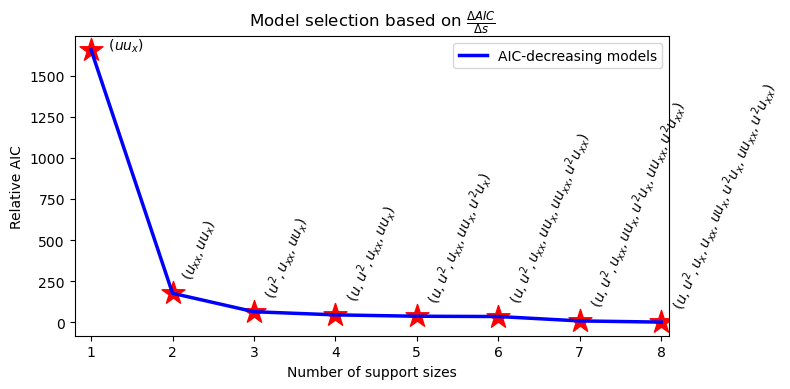

In [25]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(complexities, relative_decreasing_aics, color='blue', linewidth=2.5, label="AIC-decreasing models")
ax.scatter(complexities, relative_decreasing_aics, marker='*', c='red', s=300)
for com, name, rel_aic in zip(complexities, eff_feature_names, relative_decreasing_aics):
    rotation = (90+45)/2
    if com == 1: rotation = 0
    ax.annotate(f"    $({','.join(name)})$", (com, rel_aic), rotation=rotation)
plt.xlim(0.8,8.1)
plt.title(r"Model selection based on $\frac{\Delta AIC}{\Delta s}$")
plt.ylabel("Relative AIC")
plt.xlabel("Number of support sizes")
plt.legend()
plt.tight_layout()
# plt.savefig(join_path(FIGURE_EXPORT_PATH, "aic_model_selection.png"), dpi=300)
plt.show()

#### For training DeepONets

In [26]:
# data['un'] = un_copy+0.0j
# data['denoised_un'] = un+0.0j
# data['discovered_coefficients'] = ols_model.params
# data['feature_names'] = np.array([convert2latex(f) for i,f in enumerate(model.get_feature_names()) if i in eff_rhs_indices])
# sio.savemat("../Datasets/noisy_burgers.mat", data)

In [27]:
kalpha = 0.25
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=2, spatial_grid=x, 
                        include_bias=False, is_uniform=True, 
                        differentiation_method=KalmanDiff, differentiation_kwargs={"alpha":kalpha, "poly_deg":None, "rpca_lambda":None}
                       )
optimizer = L0BNB(max_nonzeros=2, lam=1e-3, is_normal=True, normalize_columns=False)
# optimizer = BruteForceRegressor(2)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, 
                 # differentiation_method=None, 
                 differentiation_method=KalmanDiff(alpha=kalpha, poly_deg=poly_deg, rpca_lambda=rpca_lambda, axis=1, is_uniform=True), feature_names=['u'], 
                )
model.fit(np.expand_dims(un, -1), t=dt)
model.print()

(u)' = -0.346 u_1 + 0.252 uu_11


In [28]:
# KalmanDiff -> explicit calc to Theta and u_dot ... (since implementing an extension to ps.BaseDifferentiation is quite confusing for now)
# Then, check if they are giving the same results.
# Try adding RobustPCA and Savgol (a denoising filter)

In [29]:
# Further denoise with Savgol?
# Combine with WeakPDELibrary? (VERY INTERESTING)
# can tolerate up to 120 percent noise!? -> OK, but not really good for low-noise
# f = np.expand_dims(un.copy(), -1)
f = un.copy()
f_t = KalmanDiff(alpha=kalpha, poly_deg=poly_deg, axis=1)._differentiate(f, t).reshape(-1, 1)
f_x = KalmanDiff(alpha=kalpha, poly_deg=poly_deg, axis=0)._differentiate(f, x)
f_xx = KalmanDiff(alpha=kalpha, poly_deg=poly_deg, axis=0)._differentiate(f_x, x)
f_xxx = KalmanDiff(alpha=kalpha, poly_deg=poly_deg, axis=0)._differentiate(f_xx, x)
f_xxxx = KalmanDiff(alpha=kalpha, poly_deg=poly_deg, axis=0)._differentiate(f_xxx, x)
basis_candidates = [f, f_x, f_xx, f_xxx, f_xxxx]

In [30]:
candidate_lib = []
for e in rhs_des:
    out = 1
    for o, d in get_order_degree(e, accumulate=False):
        out = out*(basis_candidates[o]**d)
    out = out.ravel().reshape(-1, 1)
    candidate_lib.append(out)
candidate_lib = np.hstack(candidate_lib)

In [31]:
print(bnb(candidate_lib, f_t, 2))
# why brute force ไม่เลือกตาม information criterion ที่ใช้ pen also from get_order_degree!!!
bf = brute_force(candidate_lib, f_t, 2, top=3, alpha=1.0)
[np.nonzero(bf[:, j:j+1])[0].tolist() for j in range(bf.shape[1])]

[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [-0.33663884 -0.34597517]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.25214857]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]


[[3, 8], [3, 9], [4, 8]]

In [32]:
ralpha = 1.0
MODEL = Ridge; kwargs = {"alpha":ralpha, "fit_intercept":False}
sk_brute_force(candidate_lib, f_t, 2, MODEL=MODEL, kwargs=kwargs, top=3)

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.34518207, -0.34407967,  0.        ],
       [ 0.        ,  0.        , -0.80834886],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.25061654,  0.        ,  0.2724939 ],
       [ 0.        ,  0.31645515,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

In [33]:
np.linalg.lstsq(candidate_lib[:, [4, 7]], f_t, rcond=None)

(array([[-0.80875319],
        [ 0.14543985]]),
 array([50.26124663]),
 2,
 array([24.59411152,  9.00514134]))

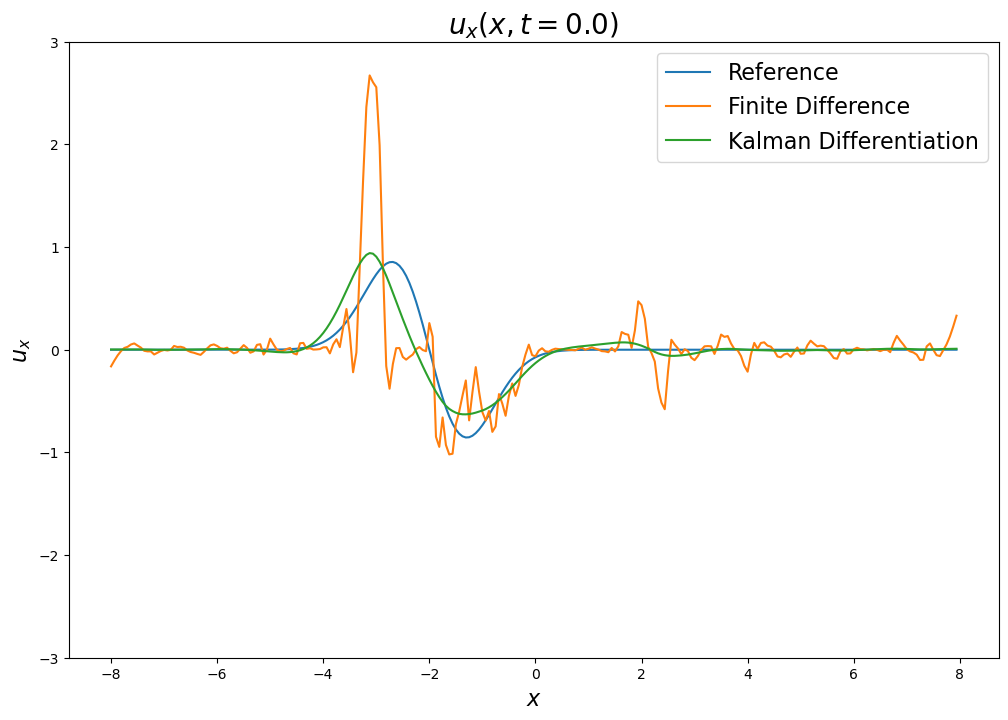

In [34]:
real_f_x = R[:, 3:4].reshape(X.shape).T
fd_x = ps.SmoothedFiniteDifference(axis=0)._differentiate(f, x)
at_time = 0
plt.plot(x, real_f_x[:, at_time:at_time+1], label="Reference")
plt.plot(x, fd_x[:, at_time:at_time+1], label="Finite Difference")
plt.plot(x, f_x[:, at_time:at_time+1], label="Kalman Differentiation")
plt.ylim(-3, 3)
plt.title(f"$u_x(x,t={t[at_time]})$", fontsize=20)
plt.ylabel("$u_x$", fontsize=16)
plt.xlabel("$x$", fontsize=16)
plt.legend(fontsize=16)
# plt.savefig(join_path(FIGURE_EXPORT_PATH, "u_x.png"), dpi=300)
plt.show()

#### Applying models to (X_pre, y_pre)

In [35]:
# frols + backward refinement is great!
# why (3, 4, 6) -> [4, 6] in noise = 0%
coeffs,selected_inds_list,full_coef,_,_ = frols(y_pre,X_pre,max_nonzeros=None)
print("Backward refining selected_inds_list by SelectKBest...")
backward_refinement(selected_inds_list, (X_pre,y_pre), mode='k best', verbose=True)

Backward refining selected_inds_list by SelectKBest...
SelectKBest
(3, 4)
(4,)
--------------------------------------------------
(1, 3, 4)
(3, 4)
--------------------------------------------------
(0, 1, 3, 4)
(1, 3, 4)
--------------------------------------------------
(0, 1, 3, 4, 5)
(0, 1, 3, 4)
--------------------------------------------------
(0, 1, 3, 4, 5, 7)
(0, 1, 3, 4, 5)
--------------------------------------------------
(0, 1, 3, 4, 5, 6, 7)
(0, 1, 3, 4, 6, 7)
(0, 1, 3, 4, 6)
(0, 1, 3, 4)
--------------------------------------------------


{1: ((4,), -50317.54355789271), 2: ((3, 4), -51800.47705156937), 3: ((1, 3, 4), -51912.94869553442), 4: ((0, 1, 3, 4), -51932.003096319386), 5: ((0, 1, 3, 4, 5), -51940.39673709334), 6: ((0, 1, 3, 4, 6, 7), -51942.084604558215), 7: ((0, 1, 3, 4, 5, 6, 7), -51968.89232136759)}

In [36]:
import pycasso
# "l1", "mcp" and "scad"
s = pycasso.Solver(normalize(X_pre, axis=0), y_pre.ravel(), 
                   penalty='scad', gamma=3, lambdas=(100, 1e-2), max_ite=10000)
s.train()
pycasso_feature_hierarchy = [e for e in sorted(list(set([tuple(np.nonzero(s.coef()['beta'][i])[0]) for i in range(100)]))) if len(e) > 0][::-1]
pycasso_feature_hierarchy

Training is over.


[(4,), (3, 4, 6), (3, 4), (2, 4), (1, 3, 4), (0, 1, 3, 4)]

In [37]:
abess_kw={'alpha':None, 'support_size':2, 'cv':5} # Try alphas: 1e2, 1e1, 1e-2, 1e-3, None
model = LinearRegression(**abess_kw, covariance_update=True)
model.fit(Rn, Utn.ravel(), is_normal=False)
print(model.coef_)
print(np.where((model.coef_ !=0.0)&(~np.isnan(model.coef_)))[0])

[ 0.          0.          0.          0.         -0.50204916  0.
  0.          0.          0.          0.          0.          0.
 -0.0202092   0.          0.        ]
[ 4 12]


In [38]:
abess_feature_hierarchy = []
abess_kw = {'alpha':1e2, 'cv':5, 'path_type':'seq'}
for ss in range(6, 0, -1): # wide range so that 3 and 4 occur together
    model = LinearRegression(support_size=ss, **abess_kw, covariance_update=True)
    model.fit(X_pre, y_pre.ravel(), is_normal=True)
    # print(model.nonnan_coeffs())
    # print(((X_pre@model.nonnan_coeffs()-y_pre.ravel())**2).mean())
    abess_feature_hierarchy.append(tuple(np.where((model.nonnan_coeffs() !=0.0)&(~np.isnan(model.nonnan_coeffs())))[0]))
abess_feature_hierarchy

[(1, 2, 3, 4, 5, 6), (1, 2, 3, 4, 5), (1, 2, 3, 4), (2, 4, 5), (3, 6), (3,)]

In [39]:
import slir
slir_feature_hierarchy = set()
for prune_threshold in range(-6, 0):
    slr = slir.SparseLinearRegression(n_iter=200, prune_threshold=10**prune_threshold)
    slr.fit(X_pre, y_pre)
    slir_feature_hierarchy.add(tuple(np.where((slr.coef_!=0.0)&(~np.isnan(slr.coef_)))[0]))
slir_feature_hierarchy

{(0, 1, 2, 3, 4, 5, 6, 7), (0, 1, 3, 4, 5, 6, 7), (4, 5, 6, 7)}

#### Backward refinement

In [40]:
print("Backward refining by SelectKBest...")
backward_refinement(abess_feature_hierarchy, (X_pre,y_pre), mode='k best', verbose=True)

Backward refining by SelectKBest...
SelectKBest
(1, 2, 3, 4, 5, 6)
(1, 3, 4, 5, 6)
(1, 3, 4, 6)
(1, 3, 4)
(3, 4)
(4,)
--------------------------------------------------
(1, 2, 3, 4, 5)
(1, 3, 4, 5)
(1, 3, 4)
--------------------------------------------------
(1, 2, 3, 4)
(1, 3, 4)
--------------------------------------------------
(2, 4, 5)
(4, 5)
(4,)
--------------------------------------------------
(3, 6)
(3,)
--------------------------------------------------


{6: ((1, 2, 3, 4, 5, 6), -51921.98020011018), 5: ((1, 3, 4, 5, 6), -51920.34591874565), 4: ((1, 3, 4, 6), -51919.31823742617), 3: ((1, 3, 4), -51912.94869553442), 2: ((3, 4), -51800.47705156937), 1: ((4,), -50317.54355789271)}

In [41]:
print("RFE refining...")
backward_refinement(abess_feature_hierarchy, (X_pre,y_pre), mode='rfe', verbose=True)

RFE refining...
RFE_PLinearRegression
(1, 2, 3, 4, 5, 6)
(1, 3, 4, 5, 6)
(1, 3, 4, 6)
(1, 3, 4)
(3, 4)
(4,)
--------------------------------------------------
(1, 2, 3, 4, 5)
(1, 3, 4, 5)
(1, 3, 4)
--------------------------------------------------
(1, 2, 3, 4)
(1, 3, 4)
--------------------------------------------------
(2, 4, 5)
(4, 5)
(4,)
--------------------------------------------------
(3, 6)
(3,)
--------------------------------------------------


{6: ((1, 2, 3, 4, 5, 6), -51921.98020011018), 5: ((1, 3, 4, 5, 6), -51920.34591874565), 4: ((1, 3, 4, 6), -51919.31823742617), 3: ((1, 3, 4), -51912.94869553442), 2: ((3, 4), -51800.47705156937), 1: ((4,), -50317.54355789271)}

In [42]:
print("mRMR refining...")
sum([backward_refinement(abess_feature_hierarchy, (X_pre,y_pre), mode='mrmr', sk_normalize_axis=0, verbose=True), 
    backward_refinement(abess_feature_hierarchy, (X_pre,y_pre), mode='mrmr', sk_normalize_axis=1, verbose=True)])

mRMR refining...
mrmr_regression
(1, 2, 3, 4, 5, 6)
(1, 3, 4, 5, 6)
(1, 3, 4, 6)
(1, 3, 4)
(1, 4)
(4,)
--------------------------------------------------
(1, 2, 3, 4, 5)
(1, 3, 4, 5)
(1, 3, 4)
--------------------------------------------------
(1, 2, 3, 4)
(1, 3, 4)
--------------------------------------------------
(2, 4, 5)
(4, 5)
(4,)
--------------------------------------------------
(3, 6)
(3,)
--------------------------------------------------
mrmr_regression
(1, 2, 3, 4, 5, 6)
(1, 3, 4, 5, 6)
(3, 4, 5, 6)
(3, 4, 5)
(3, 5)
(5,)
--------------------------------------------------
(1, 2, 3, 4, 5)
(2, 3, 4, 5)
(3, 4, 5)
--------------------------------------------------
(1, 2, 3, 4)
(2, 3, 4)
(3, 4)
(4,)
--------------------------------------------------
(2, 4, 5)
(2, 5)
(5,)
--------------------------------------------------
(3, 6)
(6,)
--------------------------------------------------


{1: ((4,), -50317.54355789271), 2: ((3, 4), -51800.47705156937), 3: ((1, 3, 4), -51912.94869553442), 4: ((1, 3, 4, 6), -51919.31823742617), 5: ((1, 3, 4, 5, 6), -51920.34591874565), 6: ((1, 2, 3, 4, 5, 6), -51921.98020011018)}

#### Hierarchical selection with BruteForce & ABESS (NOT OPTIMAL: See the include arg)

In [43]:
# lam=1e-1 | 1e-2 | 1e-3 are good choices. -> tune ตาม aic บน (X_pre, y_pre)
print(bnb(X_pre, y_pre, 3, lam=1e-1, corrected_coefficients=True))
print(bnb(X_pre, y_pre, 3, lam=1e-2, corrected_coefficients=True))
print(bnb(X_pre, y_pre, 3, lam=1e-3, corrected_coefficients=True))

[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.08762773]
 [-0.95304924 -0.99560249]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.08762773]
 [-0.95304924 -0.99560249]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.08762773]
 [-0.95304924 -0.99560249]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]


In [44]:
# training_data = (Rn.copy(), Utn.copy().ravel())
# validation_data = (Rn.copy(), Utn.copy().ravel())
training_data = (X_pre.copy(), y_pre.copy().ravel())
validation_data = (X_pre.copy(), y_pre.copy().ravel())
abess_kw = {'cv':5}; n_leaves = 3; nor = True; max_support_sizes = 5

prev_nodes = None
for ss in range(1, max_support_sizes+1):
    if prev_nodes is not None:
        ### Brute force ###
        effs_collection = set()
        for pn in prev_nodes:
            model = brute_force(training_data[0], training_data[1], support_size=ss, include=pn, top=n_leaves)
            effs = set(tuple(np.nonzero(model[:,j])[0]) for j in range(model.shape[1]))
            effs_collection = effs_collection.union(effs)
        
        ### ABESS ####
        # effs_collection = []
        # for pn in prev_nodes:
        #     selected = frozenset()
        #     for nl in range(n_leaves):
        #         candidates = Rn.copy()
        #         candidates[:, [i for i in range(Rn.shape[1]) if i in selected]] = 0.0
        #         if nor: candidates = normalize(candidates, axis=0)
        #         model = LinearRegression(support_size=ss, always_select=pn, **abess_kw).fit(candidates, Utn, is_normal=False)
        #         effs = frozenset(np.where((model.coef_ != 0.0)&(~np.isnan(model.coef_)))[0])
        #         effs_collection.append(effs)
        #         effs = effs - frozenset(pn)
        #         selected = selected.union(effs)    
        # effs_collection = set(effs_collection)
        # effs_collection = set(map(tuple, effs_collection))
        
        prev_nodes = effs_collection

    else:
        ### Brute force ###
        model = brute_force(training_data[0], training_data[1], support_size=ss, top=n_leaves)
        prev_nodes = set(tuple(np.nonzero(model[:,j])[0]) for j in range(model.shape[1]))
        
        ### ABESS ####
        # effs_collection = []
        # selected = frozenset()
        # for nl in range(n_leaves):
        #     candidates = Rn.copy()
        #     candidates[:, [i for i in range(Rn.shape[1]) if i in selected]] = 0.0
        #     if nor: candidates = normalize(candidates, axis=0)
        #     model = LinearRegression(support_size=ss, always_select=[], **abess_kw).fit(candidates, Utn)
        #     effs = frozenset(np.where((model.coef_ != 0.0)&(~np.isnan(model.coef_)))[0])
        #     effs_collection.append(effs)
        #     selected = selected.union(effs)
        # effs_collection = set(effs_collection)
        # prev_nodes = set(map(tuple, effs_collection))
        
        ### for testing ###
        # prev_nodes = {(4,), (3,), (7, )}
        
    # Performance validation
    scores = []
    for pn in prev_nodes:
        w = np.linalg.lstsq(validation_data[0][:, pn], validation_data[1], rcond=None)[0]
        mse = mean_squared_error(validation_data[0][:, pn]@w, validation_data[1])
        scores.append((mse, pn))
    scores = sorted(scores)
    prev_nodes = [v for k,v in scores][:n_leaves]
    print(prev_nodes)
    print(scores[:n_leaves])
    print('---')
    prev_nodes = set(prev_nodes)

[(4,), (2,), (5,)]
[(0.00038209875, (4,)), (0.0004024662, (2,)), (0.00040721215, (5,))]
---
[(3, 4), (4, 6), (4, 7)]
[(0.00032937134, (3, 4)), (0.0003353223, (4, 6)), (0.00034184055, (4, 7))]
---
[(1, 3, 4), (3, 4, 6), (3, 4, 7)]
[(0.00032562247, (1, 3, 4)), (0.00032562818, (3, 4, 6)), (0.00032594192, (3, 4, 7))]
---
[(0, 1, 3, 4), (1, 3, 4, 6), (1, 3, 4, 7)]
[(0.0003249376, (0, 1, 3, 4)), (0.00032535003, (1, 3, 4, 6)), (0.00032543234, (1, 3, 4, 7))]
---
[(0, 1, 3, 4, 5), (0, 1, 2, 3, 4), (0, 1, 3, 4, 6)]
[(0.00032460006, (0, 1, 3, 4, 5)), (0.00032486083, (0, 1, 2, 3, 4)), (0.00032488137, (0, 1, 3, 4, 6))]
---


In [45]:
np.nonzero(brute_force(X_pre, y_pre, 5).ravel())

(array([0, 1, 3, 4, 5]),)

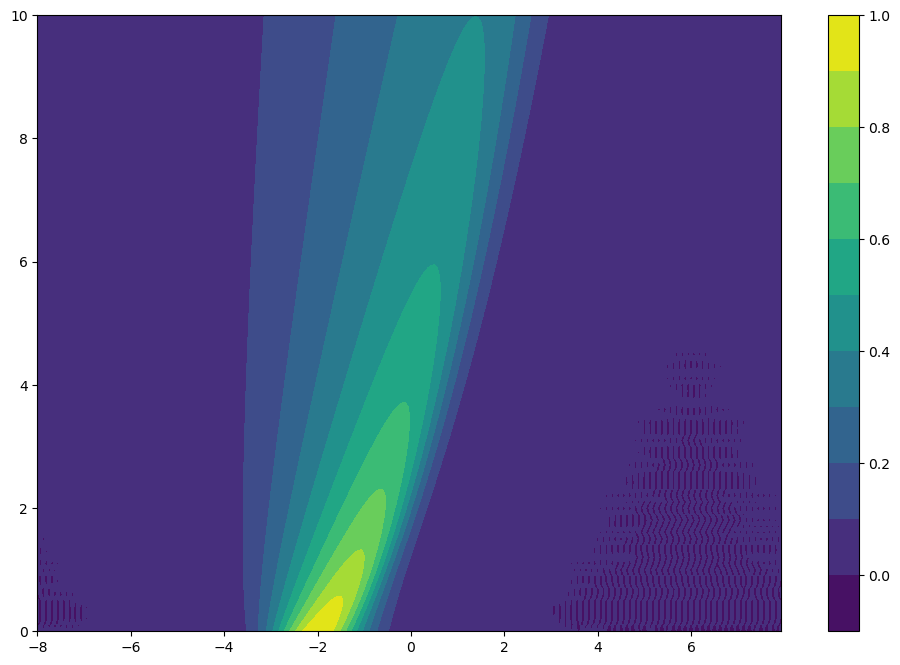

In [46]:
plt.contourf(X, T, u.T, 10)
plt.colorbar();

In [47]:
# plt.contourf(X, T, un_copy.T, 10)
# plt.xlabel("$x$", fontsize=16)
# plt.ylabel("$t$", fontsize=16)
# plt.title("Noisy $u$", fontsize=20)
# plt.colorbar()
# # plt.savefig(join_path(FIGURE_EXPORT_PATH, "noisy_u.png"), dpi=300)
# plt.show()

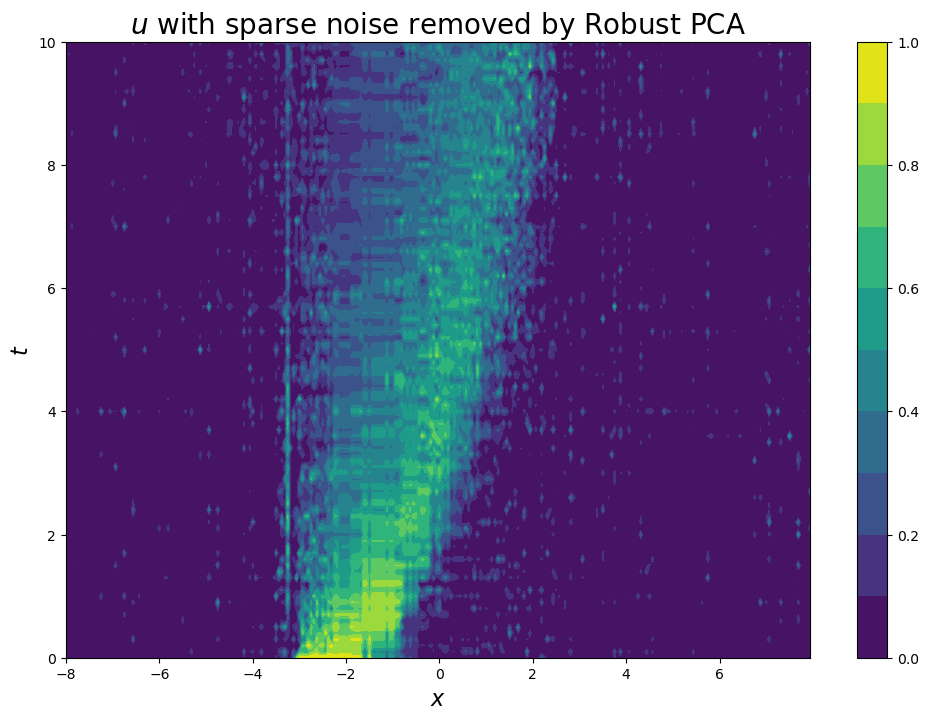

In [48]:
# chk if min(un) < 0 ? -> Possible Bug
plt.contourf(X, T, un.T, 10)
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$t$", fontsize=16)
plt.title("$u$ with sparse noise removed by Robust PCA", fontsize=20)
plt.colorbar()
# plt.savefig(join_path(FIGURE_EXPORT_PATH, "rpca_u.png"), dpi=300)
plt.show()

#### Notes
    - Hierachical selections helps.
    - WeakPDELibrary helps.
    - L0BNB helps.
    - l0bnb > frols > pycasso > slir > abess
    - except l0bnb: best-subset selection methods do not really work with Robust PCA.
    - SelectKBest > RFE > mRMR (can be improved?)